In [7]:
# Imports
import cv2 #version 3.3.1
import numpy as np
import matplotlib.pyplot as plt
import math
import os

In [8]:
def resize(img):
    d = 1024 / img.shape[1]
    dim = (1024, int(img.shape[0] * d))
    return cv2.resize(img, dim, interpolation=cv2.INTER_AREA)

def plot(img, title, size, gray):
    plt.figure(figsize=size)
    if gray=='gray':
         plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()
    
def size_lookup(wert):
    real_diam = 0;
    
    if wert == 1:
        real_diam = 16.25
    elif wert == 2:
        real_diam = 18.75
    elif wert == 5:
        real_diam = 21.25
    elif wert == 10:
        real_diam = 19.75
    elif wert == 20:
        real_diam = 22.25
    elif wert == 50:
        real_diam = 24.25
    elif wert == 100:
        real_diam = 23.25
    elif wert == 200:
        real_diam = 25.75
            
    return real_diam

def gray(img):
    # Graustufenumwandlung
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_gray

def contrast_enhancement(img):
    # Anwenden der Kontrastverstärkung
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_enhanced = clahe.apply(img)
    return img_enhanced

def gauss_blurr(img):
    img_blurred = cv2.GaussianBlur(img, (7, 7), 0)
    return img_blurred

def get_values(diam, mat):
    values = []
    
    i = 0
    total = 0
    for d in diam:
        t = "Unknown"
        toAdd = 0

        # compare to known diameters with some margin for error
        if mat[i] == "gold/silber": #and math.isclose(d, 25.75, abs_tol=1.25) 
            t = "2 Euro"
            toAdd = 200
        elif mat[i] == "silber/gold": #and math.isclose(d, 23.25, abs_tol=2.5)
            t = "1 Euro"
            toAdd = 100
        elif mat[i] == "gold":
            if d < 18.5:
                t = "10 Cent"
                toAdd = 10
            elif math.isclose(d, 19.75, abs_tol=1.25):
                t = "10 Cent"
                toAdd = 10
            elif math.isclose(d, 22.25, abs_tol=1.25):
                t = "20 Cent"
                toAdd = 20
            elif math.isclose(d, 24.25, abs_tol=2.5):
                t = "50 Cent"
                toAdd = 50
            elif d > 26.75:
                t = "50 Cent"
                toAdd = 50
            
        elif mat[i] == "kupfer":
            if d < 15:
                t = "1 Cent"
                toAdd = 1
            elif math.isclose(d, 16.25, abs_tol=1.25):
                t = "1 Cent"
                toAdd = 1
            elif math.isclose(d, 18.75, abs_tol=1.25):
                t = "2 Cent"
                toAdd = 2
            elif math.isclose(d, 21.25, abs_tol=2.5):
                t = "5 Cent"
                toAdd = 5
            elif d > 23.75:
                t = "5 Cent"
                toAdd = 5
        
        total += toAdd
        values.append(t)
        
        i += 1
        
    return(values, total)

def classify_coin(coin):
# Randerkennung:
    
    # Randauschnitt und Ausschnitt aus Mitte
    rand = coin[5:10, 5:10]
    height, width, _ = coin.shape
    mitte = coin[int(height/2)-10:int(height/2)+10, int(width/2)-10:int(width/2)+10]
    #mitte = coin[int(height/2)-3:int(height/2)+2, int(width/2)-2:int(width/2)+3]
    
    # Farben berechnen
    randColor = rand.mean(axis=(0, 1))
    mitteColor = mitte.mean(axis=(0,1))
    
    if debugMaterialerkennung:
        plot(coin, "Münzauschnitt", (2,2), _)
        plot(rand, "Rand", (2,2), _)
        plot(mitte, "Mitte", (2,2), _)
    
# Materialerkennung
# Annahmen beruhen auf Analyse einiger Bilder + Internetrecherche
    mat = -1
    matRand = -1
    
    # Material am Rand erkennen
    aRand = randColor[1] - randColor[0] 
    bRand = mitteColor[1] - mitteColor[2]
    xRand = abs(aRand) - abs(bRand)
    if xRand > 10:
        matRand = 1 
    else:
        matRand = 0 
        
    # Matrial in Mitte erkennen
    aMitte = mitteColor[1] - mitteColor[0] 
    bMitte = mitteColor[1] - mitteColor[2]
    xMitte = abs(aMitte) - abs(bMitte)
    if xMitte > 10:
        mat = 1
    else:
        mat = 0
    
    if debugMaterialerkennung:
        print('mat: ', mat)
        print('matrand: ', matRand)
    # bei Farbabweichung -> Materialmix
    if mat != matRand:
        #Prüfe Verhältnis von Rand zur Mitte
        #if abs(mitte_color[1] - rand_color[1]) >= 20 and abs(mitte_color[2] - rand_color[2]) >= 20:
        #if randColor[0] > 115:
        if (mitteColor[1] - mitteColor[0]) > 15:
            return "gold/silber" #2 Euro
        #elif randColor[0] <= 115:
        elif (mitteColor[1] - mitteColor[0]) <= 15:
            return('silber/gold') #1 Euro
    elif mat == 1:
        return('gold')
    else: 
        return('kupfer')

def refineRad(img, r):
    img_g = gray(img)
    img_g = contrast_enhancement(img_g)
    img_blurred = gauss_blurr(img_g)
    c = cv2.HoughCircles(img_blurred, cv2.HOUGH_GRADIENT, dp=2.2, minDist=100, param1=200, param2=100, minRadius=r-5, maxRadius=r+5)
    if c is not None:
        c = np.round(c[0, :]).astype("int")
        # Kreis zeichnen
        if debugDurchmessererkennung:
            print('Erste Messung: ',r)
            print('Refinement: ', c[0][2])
        return (c[0][2] + r) // 2
    # falls keine Kreise erkannt werden, ursprünglichen Durchmesser zurückgeben
    return r

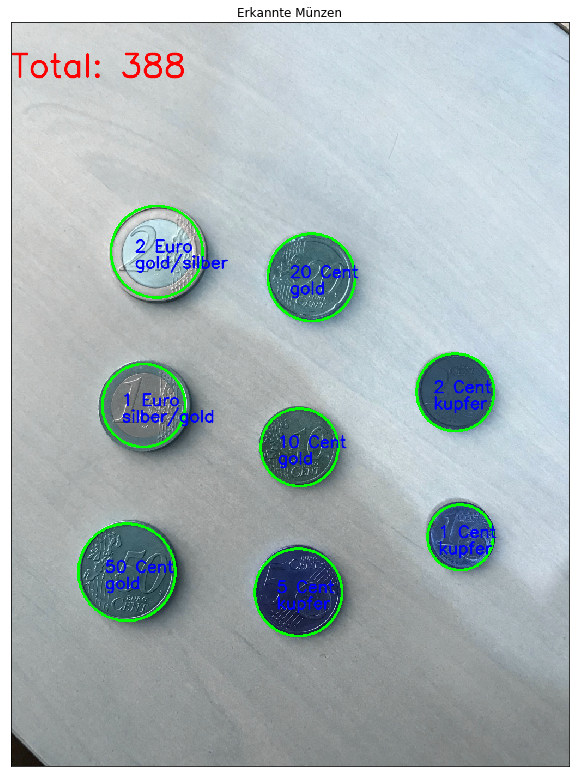

In [9]:
filename = "1_2.JPG"
smallest_coin_value = 1
debugMaterial = True
debugMaterialerkennung = False
debugDurchmesser = False
debugDurchmessererkennung = False

# Datei einlesen
image = cv2.imread(filename)
if image is None:
    print("Unable to open " + filename)
    exit(-1)
    
# Größe anpassen
image = resize(image)
    
# Kopie erstellen für Zeichnungen
image_cpy = image.copy()

image_gray = gray(image)
image_gray = contrast_enhancement(image_gray)
blurred = gauss_blurr(image_gray)

#plot(blurred, "bild", (10,20), gray)

circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=2.2, minDist=100, param1=200, param2=100, minRadius=60, maxRadius=120)

diam = []
mat = []

if circles is not None:
    # runden der Zahlen
    circles = np.round(circles[0, :]).astype("int")
        
    # durch alle erkannten Kreise durchiterieren
    for (x, y, rad) in circles:
        # Durchmesser der Münze aus Ausschnitt nochmal bestimmen (refinement)
        tmp_img = image[y - rad-20:y + rad+20, x - rad-20:x + rad+20]
        rad = refineRad(tmp_img, rad)
        diam.append(rad)
        # Münze ausschneiden und klassifizieren
        res = classify_coin(image[y - rad+25:y + rad-25, x - rad+25:x + rad-25])
        mat.append(res)
        # Kreis zeichnen
        cv2.circle(image_cpy, (x, y), rad, (0, 255, 0), 4)
        if debugMaterial:
            cv2.putText(image_cpy, res, (x-40,y+30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), thickness=2, lineType=cv2.LINE_AA)

            
    smallest = min(diam)

    # Mittelwert der kleinsten münzen +-5?
    i = 0
    size = 0
    for val in sorted(diam):
        if(val <= smallest + 5):
            size = size + val
            i = i+1
    
    size = size//i
    smallest = size
    
    # größe der kleinsten Münze herausfinden
    size = size_lookup(smallest_coin_value)

    diam = [x / smallest * size for x in diam]

    val = get_values(diam, mat)

# Wert aller Münzen ins Bild eintragen
    i = 0
    for (x, y, rad) in circles:
        cv2.putText(image_cpy, val[0][i], (x-40,y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), thickness=2, lineType=cv2.LINE_AA)
        if debugDurchmesser:
            cv2.putText(image_cpy, str("{0:.2f}".format(diam[i])), (x-40,y-30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), thickness=2, lineType=cv2.LINE_AA)
        i += 1

# Gesamtwert ins Bild eintragen
    cv2.putText(image_cpy, "Total: "+ str(val[1]), (0,100), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), thickness=3, lineType=cv2.LINE_AA)
    
plot(image_cpy, 'Erkannte Münzen', (10,20), _)
base = os.path.basename(filename)
name = os.path.splitext(base)[0]
cv2.imwrite(name+'_counted.JPG', image_cpy);